In [ ]:
import numpy as np
import scipy.optimize
from scipy.integrate import odeint
from scipy.linalg import solve_continuous_are
from sympy import *
import sympy as sym
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
# Constants

m = 0.73362  # Drone mass (kg)
m_prop = 0.03 #Mass of props (Kg)
g = -9.81  # Gravitational acceleration (m/s^2)
p_d = 0.17 # Diameter of propellers (m)
C_t = 0.1  # Thrust coefficient
C_q = 4e-3  # Torque coefficient
l = 0.25  # Length between the individual rotor and drone center (m)

# Inertia
I_xx = I_yy = 1/12 * (m/2) * l**2  # Inertia about x and y axes (kg*m^2)
I_zz = 2 * I_xx  # Inertia about z axis (kg*m^2)
I_r = 1/12 * m_prop * p_d**2  # Inertia of each rotor (kg*m^2); Assuming that can approximate the total I of drone as two rods


# Lift and torque constants
k = C_t * p_d**4 * (2 * np.pi)  # Lift constant calculation
b = C_q * p_d**5 * (2 * np.pi)  # Torque constant calculation

print(k, b)

0.0005247779200409465 3.5684898562784352e-06


In [ ]:
# Initial conditions

px0, py0, pz0 = 0.0, 0.0, 0.0  # Initial x, y, z positions
vx0, vy0, vz0 = 0.0, 0.0, 0.0  # Initial velocities along x, y, z axes
phi0, theta0, psi0 = 0.0, 0.0, 0.0  # Initial roll, pitch, yaw angles
omegax_0, omegay_0, omegaz_0 = 0.0, 0.0, 0.0  # Initial angular velocities about x, y, z axes
omega1_0, omega2_0, omega3_0, omega4_0 = 0.0, 0.0, 0.0, 0.0  # Initial rotor angular velocities
energy_total = 0.0  # Initial energy

In [ ]:
#Equilibirum
Px, Py, Pz, vx, vy, vz, phi, theta, psi, omegax, omegay, omegaz, omega1, omega2, omega3, omega4 = symbols('Px, Py, Pz, vx, vy, vz, phi, theta, psi, omegax, omegay, omegaz, omega1, omega2, omega3, omega4')
tau1, tau2, tau3, tau4 = symbols('tau1, tau2, tau3, tau4')

# State and input matrices
State_Matrix = [Px, Py, Pz, vx, vy, vz, phi, theta, psi, omegax, omegay, omegaz, omega1, omega2, omega3, omega4]
inputs = [tau1, tau2, tau3, tau4]

#Equation of Motion
F  = Matrix([vx,
             vy,
             vz,
             k*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             -k*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             (g*m + k*(omega1**2 + omega2**2 + omega3**2 + omega4**2)*cos(phi)*cos(theta))/m,
             omegax,
             omegay,
             omegaz,
            (-I_xx*I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi)*tan(theta) - I_xx*I_zz*k*l*(omega1**2 - omega3**2)*sin(phi)*tan(theta) - I_yy*I_zz*k*l*(omega2**2 - omega4**2))/(I_xx*I_yy*I_zz),
            (I_yy*(tau1 - tau2 + tau3 - tau4)*sin(phi) - I_zz*k*l*(omega1**2 - omega3**2)*cos(phi))/(I_yy*I_zz),
            (-I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi) - I_zz*k*l*(omega1**2 - omega3**2)*sin(phi))/(I_yy*I_zz*cos(theta)),
            (-b*omega1**2 + tau1)/I_r,
            (-b*omega2**2 + tau2)/I_r,
            (-b*omega3**2 + tau3)/I_r,
            (-b*omega4**2 + tau4)/I_r]).T

# Define zero substitutions for various variables
zero_subs = {Px: 0.0, Py: 0.0, Pz: 0.0, vx: 0.0, vy: 0.0, vz: 0.0, phi: 0.0, theta: 0.0, psi: 0.0, omegax: 0.0, omegay: 0.0, omegaz: 0.0}

# Apply substitutions to F
F_equil = F.subs(zero_subs)
equations = [Eq(F_equil[i], 0.0) for i in [5, 6, 7, 8, 12, 13, 14, 15]]
tau_equations = [Eq(tau1, tau2), Eq(tau3, tau4), Eq(tau1, tau3)]
all_equations = equations + tau_equations
solution = solve(all_equations)[15]


print(solution)

{omega1: 58.5534261852300, omega2: 58.5534261852300, omega3: 58.5534261852300, omega4: 58.5534261852300, tau1: 0.0122345807400000, tau2: 0.0122345807400000, tau3: 0.0122345807400000, tau4: 0.0122345807400000}


In [ ]:
#Matrices

solution_mapping = solution
initial_conditions = {
    'Px': 0.0, 'Py': 0.0, 'Pz': 0.0,
    'vx': 0.0, 'vy': 0.0, 'vz': 0.0,
    'phi': 0.0, 'theta': 0.0, 'psi': 0.0,
    'omegax': 0.0, 'omegay': 0.0, 'omegaz': 0.0
}

# Evaluate the equilibrium
F_equil = F_equil.subs(solution_mapping).subs(initial_conditions)
print(F_equil)

# Calculate the Jacobian matrix A
A = F.jacobian(State_Matrix)
A = A.subs(solution_mapping).subs(initial_conditions)
A = np.array(A).astype(float)

# Calculate the Jacobian matrix B
B = F.jacobian(inputs)
B = B.subs(solution_mapping).subs(initial_conditions)
B = np.array(B).astype(float)

# Evaluate the inputs and state matrix
inputs_equil = np.array(Matrix(inputs).subs(solution_mapping).subs(initial_conditions)).astype(float)
state_equil = np.array(Matrix(State_Matrix).subs(solution_mapping).subs(initial_conditions)).astype(float)

print(inputs_equil)


Matrix([[0, 0, 0, 0, 0, 1.77635683940025e-15, 0, 0, 0, 0, 0, 0, -1.42108547152020e-13, -1.42108547152020e-13, -1.42108547152020e-13, -1.42108547152020e-13]])
[[0.01223458]
 [0.01223458]
 [0.01223458]
 [0.01223458]]


In [ ]:
def LQR(A, B, Q, R):
    P = scipy.linalg.solve_continuous_are(A, B, Q, R)
    K = np.linalg.inv(R) @  B.T @ P
    return K

Q = np.diag([10,10,200,1,1,1,1,1,100,1,1,1,1,1,1,1])
R = np.eye(4)*100
K = LQR(A, B, Q, R)

In [ ]:
 # Create the Controller class
class Controller():
    def __init__(self):
        pass
    def reset(self, x_0):
        x = x_0
        pass
    def run(self, x, x_desired):
       x_error = ((x).flatten()- (x_desired).flatten())
       tau = -K@x_error + inputs_equil.flatten()
       tau = np.clip(tau, -1, 1)
       tau1,tau2,tau3,tau4 = (tau[0]),(tau[1]),(tau[2]),(tau[3])
       return [tau1,tau2,tau3,tau4]
controller = Controller()

Plots

In [ ]:
def plot(x_out, t, last = false):
    # Extracting position, Euler angles, and velocity data
    x, y, z = x_out[:, 0], x_out[:, 1], x_out[:, 2]
    phi, theta, psi = x_out[:, 6], x_out[:, 7], x_out[:, 8]
    vx, vy, vz = x_out[:, 3], x_out[:, 4], x_out[:, 5]
    phi = np.rad2deg(phi)
    theta = np.rad2deg(theta)
    psi = np.rad2deg(psi)

    fig = plt.figure(figsize=(18, 12))

    # 3D plot for position
    ax1 = fig.add_subplot(231, projection='3d')
    ax1.scatter(x, y, z)
    ax1.set_title('Position of Drone over Time')
    ax1.set_xlabel('X-axis (meters)')
    ax1.set_ylabel('Y-axis (meters)')
    ax1.set_zlabel('Z-axis (meters)')
    ax1.set_xlim([min(x)-1, max(x)+1])
    ax1.set_ylim([min(y)-1, max(y)+1])
    ax1.set_zlim([min(z)-1, max(z)+1])

    # Euler angles vs. time
    ax2 = fig.add_subplot(232)
    ax2.plot(t, phi, label='Roll (phi)')
    ax2.plot(t, theta, label='Pitch (theta)')
    ax2.plot(t, psi, label='Yaw (psi)')
    ax2.set_title('Euler Angles vs. Time')
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Angle (radians)')
    ax2.legend()

    # Velocity plot
    ax3 = fig.add_subplot(233)
    ax3.plot(t, vx, label='Vx')
    ax3.plot(t, vy, label='Vy')
    ax3.plot(t, vz, label='Vz', linestyle='--')
    ax3.set_title('Velocity Components over Time')
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Velocity (m/s)')
    ax3.legend()

    plt.tight_layout()
    plt.show()
    pass

Step 1. Start from the ground and hover at 1m

In [ ]:
x_desired = np.array([[0.0], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [58.5534261852300], [58.5534261852300], [58.5534261852300], [58.5534261852300]]).T

def derivatives(x, K, x_desired = x_desired):
  Px, Py, Pz, vx, vy, vz, phi, theta,  psi, omegax, omegay, omegaz ,omega1 ,omega2, omega3, omega4 = (x)
  tau = controller.run(x, x_desired)
  tau1,tau2,tau3,tau4 =  tau
  F  = np.array([vx,
             vy,
             vz,
             k*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             -k*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             (g*m + k*(omega1**2 + omega2**2 + omega3**2 + omega4**2)*cos(phi)*cos(theta))/m,
             omegax,
             omegay,
             omegaz,
            (-I_xx*I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi)*tan(theta) - I_xx*I_zz*k*l*(omega1**2 - omega3**2)*sin(phi)*tan(theta) - I_yy*I_zz*k*l*(omega2**2 - omega4**2))/(I_xx*I_yy*I_zz),
            (I_yy*(tau1 - tau2 + tau3 - tau4)*sin(phi) - I_zz*k*l*(omega1**2 - omega3**2)*cos(phi))/(I_yy*I_zz),
            (-I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi) - I_zz*k*l*(omega1**2 - omega3**2)*sin(phi))/(I_yy*I_zz*cos(theta)),
            (-b*omega1**2 + tau1)/I_r,
            (-b*omega2**2 + tau2)/I_r,
            (-b*omega3**2 + tau3)/I_r,
            (-b*omega4**2 + tau4)/I_r]).astype(float)
  return F


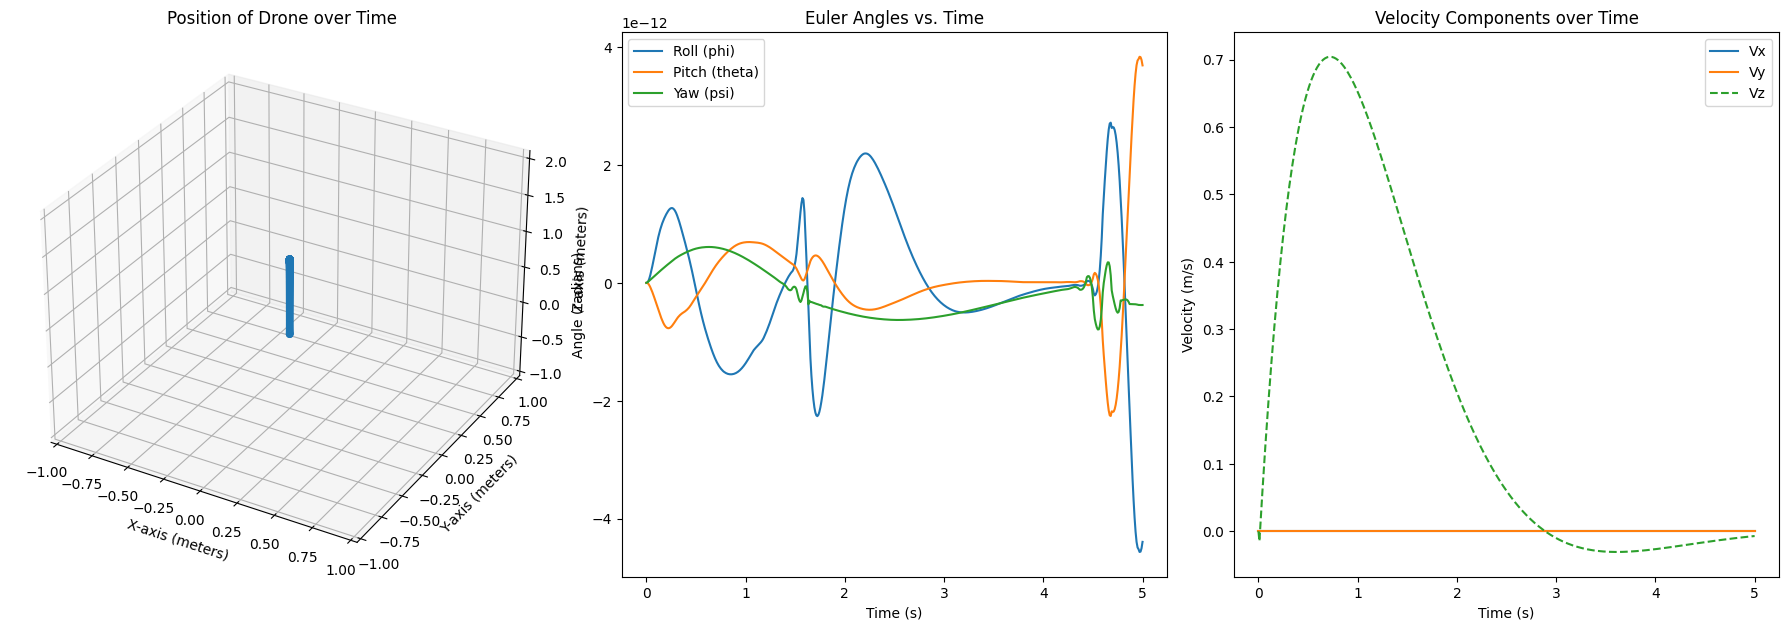

In [ ]:
steps = 500
time = 5
t = np.linspace(0, time, steps, derivatives)

x_0 = [px0, py0, pz0, vx0, vy0, vz0, phi0, theta0, psi0, omegax_0, omegay_0, omegaz_0, omega1_0, omega2_0, omega3_0, omega4_0]

def sim(x_0, t, derivatives = derivatives):
    t = np.linspace(0, time, steps)
    controller.reset(x_0)
    x_out = scipy.integrate.odeint(derivatives, x_0, t)
    Px_output, Py_output, Pz_output, vx_output, vy_output, vz_output, phi_output, theta_output, psi_output, omegax_output, omegay_output, omegaz_output, omega1_output, omega2_output, omega3_output, omega4_output  = x_out.T
    plot(x_out, t)
    return x_out, Px_output, Py_output, Pz_output, vx_output, vy_output, vz_output, phi_output, theta_output, psi_output, omegax_output, omegay_output, omegaz_output, omega1_output, omega2_output, omega3_output, omega4_output

x_out, Px_output, Py_output, Pz_output, vx_output, vy_output, vz_output, phi_output, theta_output, psi_output, omegax_output, omegay_output, omegaz_output, omega1_output, omega2_output, omega3_output, omega4_output = sim(x_0,t)

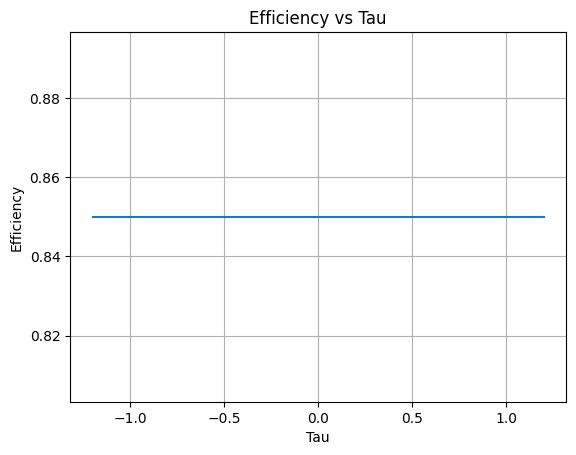

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the efficiency function
def efficiency(tau):
    """Calculate the efficiency based on the magnitude of tau."""
    return 0.85  # This example always returns 0.85, adjust as needed for different conditions

# Generate tau values and compute efficiency for each
tau_values = np.linspace(-1.2, 1.2, 1000)
efficiency_values = [efficiency(tau) for tau in tau_values]

# Plotting efficiency versus tau
plt.plot(tau_values, efficiency_values)
plt.xlabel('Tau')
plt.ylabel('Efficiency')
plt.title('Efficiency vs Tau')
plt.grid(True)

def energy(x_out, x_desired, time, steps):
    power_total = 0
    energy = 0
    for i in range(len(Px_output)):
        tau = controller.run(x_out[i], x_desired)
        tau1,tau2,tau3,tau4 =  tau
        power = (np.abs(tau1*omega1_output[i] / efficiency(tau1)) + np.abs(tau2*omega2_output[i] / efficiency(tau2))
        + np.abs(tau3*omega3_output[i] / efficiency(tau3)) + np.abs(tau4*omega4_output[i] / efficiency(tau4) ) )
        power_total += power
        energy = power_total * (time/steps)
    return energy


In [ ]:
print(x_out[-1], energy_total + energy(x_out, x_desired, time, steps))

[-1.53375934e-14 -2.03851360e-14  1.00042716e+00  9.52142856e-15
  9.20117854e-15 -7.21492179e-03 -7.66850043e-14  6.43848807e-14
 -6.55777309e-15  4.94070997e-13 -4.18440013e-13  3.14968456e-13
  5.85974164e+01  5.85974164e+01  5.85974164e+01  5.85974164e+01] 16.699532737973012


Step 2. Move Foreward 5m

In [ ]:
x_0 = x_out[-1]
energy_output = energy(x_out, x_desired, time, steps)

In [ ]:
def derivatives(x, K, x_desired = x_desired):
  Px, Py, Pz, vx, vy, vz, phi, theta,  psi, omegax, omegay, omegaz ,omega1 ,omega2, omega3, omega4 = (x)
  x_desired = np.array([[x[0] + 0.8], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [58.5534261852300], [58.5534261852300], [58.5534261852300], [58.5534261852300]]).T
  tau = controller.run(x, x_desired)
  tau1,tau2,tau3,tau4 =  tau
  F  = np.array([vx,
             vy,
             vz,
             k*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             -k*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             (g*m + k*(omega1**2 + omega2**2 + omega3**2 + omega4**2)*cos(phi)*cos(theta))/m,
             omegax,
             omegay,
             omegaz,
            (-I_xx*I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi)*tan(theta) - I_xx*I_zz*k*l*(omega1**2 - omega3**2)*sin(phi)*tan(theta) - I_yy*I_zz*k*l*(omega2**2 - omega4**2))/(I_xx*I_yy*I_zz),
            (I_yy*(tau1 - tau2 + tau3 - tau4)*sin(phi) - I_zz*k*l*(omega1**2 - omega3**2)*cos(phi))/(I_yy*I_zz),
            (-I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi) - I_zz*k*l*(omega1**2 - omega3**2)*sin(phi))/(I_yy*I_zz*cos(theta)),
            (-b*omega1**2 + tau1)/I_r,
            (-b*omega2**2 + tau2)/I_r,
            (-b*omega3**2 + tau3)/I_r,
            (-b*omega4**2 + tau4)/I_r]).astype(float)
  return F

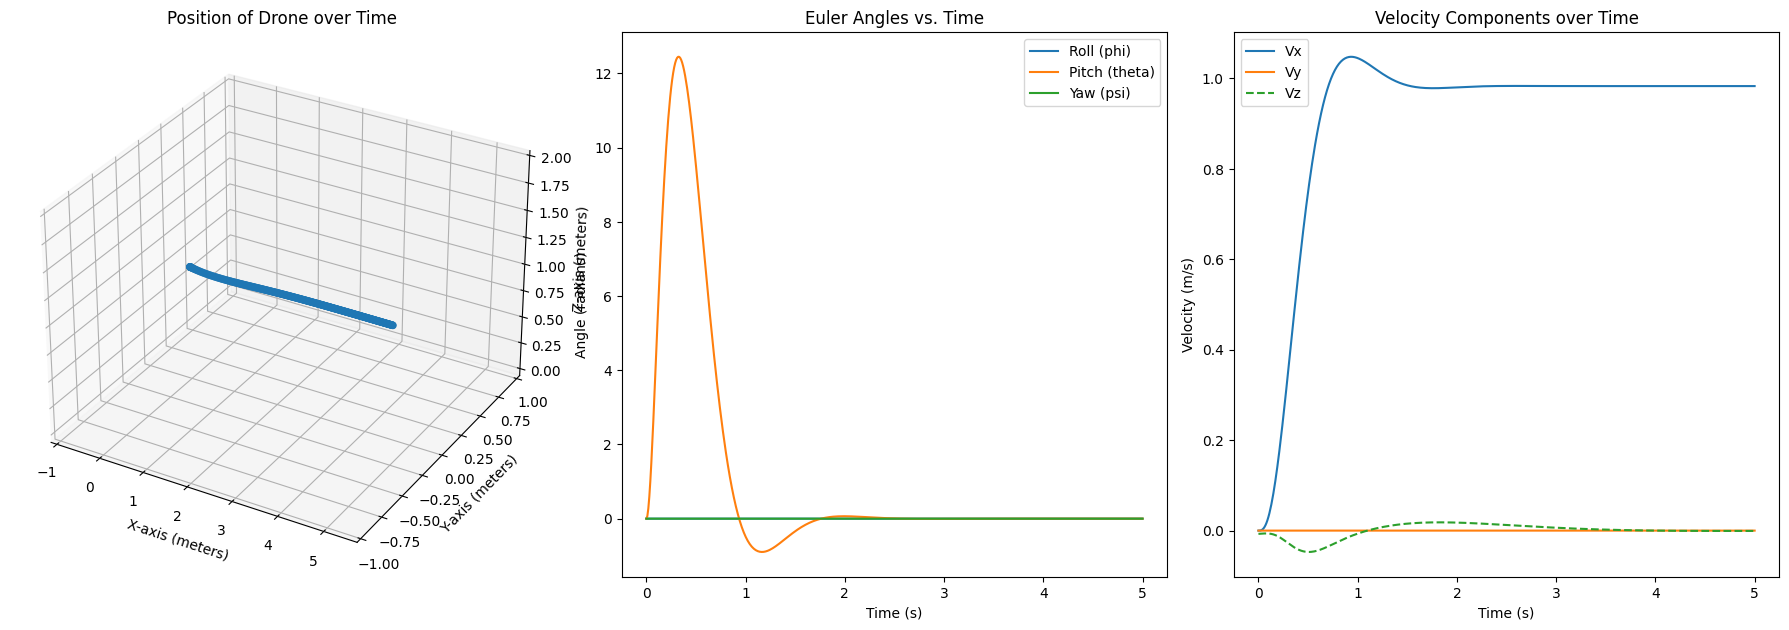

In [ ]:
steps = 500
time = 5
t = np.linspace(0, time, steps)

x_out, Px_output, Py_output, Pz_output, vx_output, vy_output, vz_output, phi_output, theta_output, psi_output, omegax_output, omegay_output, omegaz_output, omega1_output, omega2_output, omega3_output, omega4_output = sim(x_0, t, derivatives)

In [ ]:
energy1 = 0
power_total = 0
for i in range(len(Px_output)):
    x_desired = np.array([[x_out[i,0] + 0.8], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [58.5534261852300], [58.5534261852300], [58.5534261852300], [58.5534261852300]]).T
    tau = controller.run(x_out[i], x_desired)
    tau1,tau2,tau3,tau4 =  tau

    power = (np.abs(tau1*omega1_output[i] / efficiency(tau1)) + np.abs(tau2*omega2_output[i] / efficiency(tau2))
    + np.abs(tau3*omega3_output[i] / efficiency(tau3)) + np.abs(tau4*omega4_output[i] / efficiency(tau4) ) )
    power_total += power
    energy1 = power_total * (time/steps)

In [ ]:
x_out[-1], energy_total + energy1

(array([ 4.57580018e+00,  2.43997110e-09,  1.00050379e+00,  9.82830315e-01,
        -9.23578702e-09, -7.17537517e-04, -8.73335874e-10, -3.11145273e-08,
         6.85921755e-07, -7.59907437e-09,  4.95466772e-07, -9.09182919e-07,
         5.85545390e+01,  5.85545395e+01,  5.85545387e+01,  5.85545395e+01]),
 17.132113636152102)

Step 3. Stop

In [ ]:
x_0 = x_out[-1]
energy_total =  energy_total + energy1

In [ ]:
x_desired = np.array([[5], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [58.5534261852300], [58.5534261852300], [58.5534261852300], [58.553426185]])
def derivatives(x, K, x_desired = x_desired):
  Px, Py, Pz, vx, vy, vz, phi, theta,  psi, omegax, omegay, omegaz ,omega1 ,omega2, omega3, omega4 = (x)
  tau = controller.run(x, x_desired)
  tau1,tau2,tau3,tau4 =  tau
  F  = np.array([vx,
             vy,
             vz,
             k*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             -k*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             (g*m + k*(omega1**2 + omega2**2 + omega3**2 + omega4**2)*cos(phi)*cos(theta))/m,
             omegax,
             omegay,
             omegaz,
            (-I_xx*I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi)*tan(theta) - I_xx*I_zz*k*l*(omega1**2 - omega3**2)*sin(phi)*tan(theta) - I_yy*I_zz*k*l*(omega2**2 - omega4**2))/(I_xx*I_yy*I_zz),
            (I_yy*(tau1 - tau2 + tau3 - tau4)*sin(phi) - I_zz*k*l*(omega1**2 - omega3**2)*cos(phi))/(I_yy*I_zz),
            (-I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi) - I_zz*k*l*(omega1**2 - omega3**2)*sin(phi))/(I_yy*I_zz*cos(theta)),
            (-b*omega1**2 + tau1)/I_r,
            (-b*omega2**2 + tau2)/I_r,
            (-b*omega3**2 + tau3)/I_r,
            (-b*omega4**2 + tau4)/I_r]).astype(float)
  return F

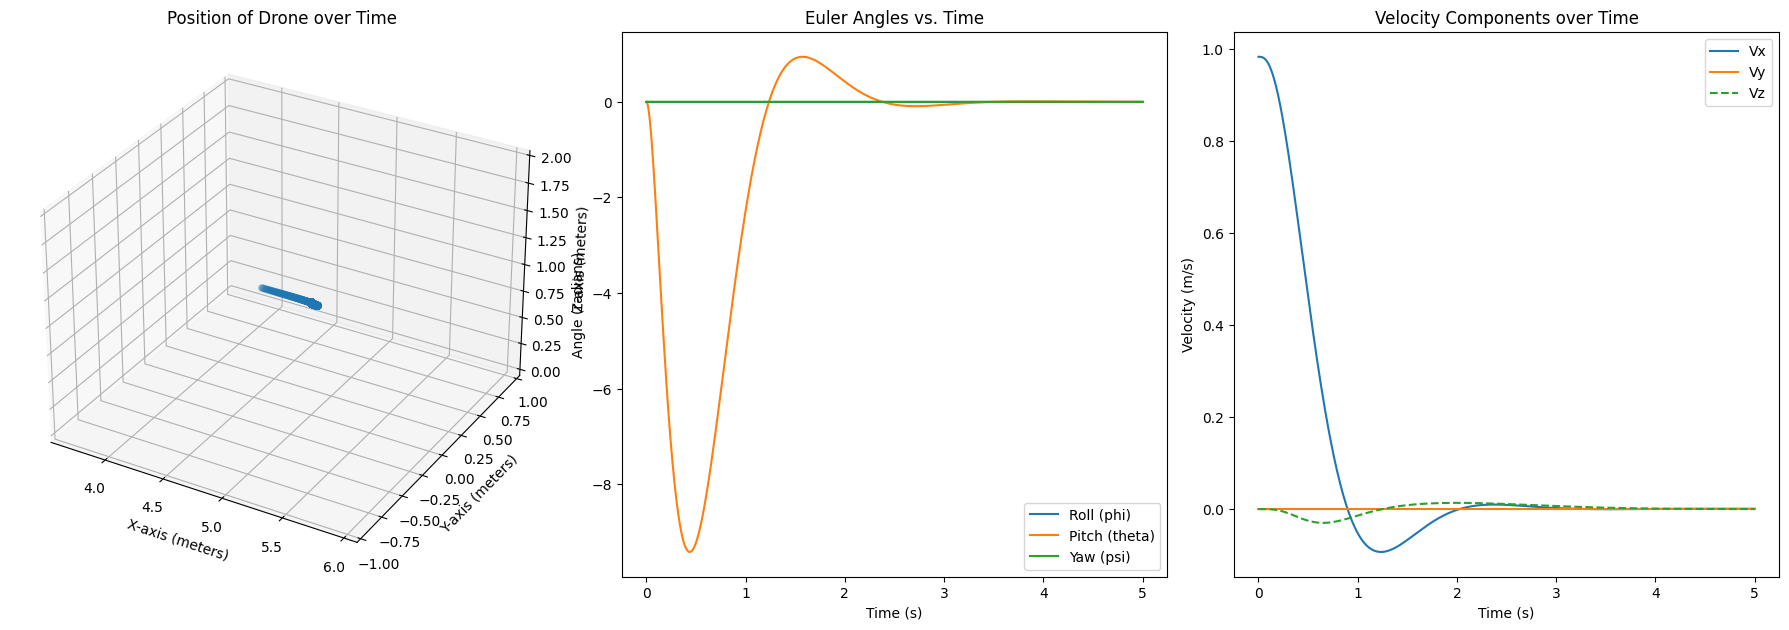

In [ ]:
steps = 500
time = 5
t = np.linspace(0, time, steps)

x_out, Px_output, Py_output, Pz_output, vx_output, vy_output, vz_output, phi_output, theta_output, psi_output, omegax_output, omegay_output, omegaz_output, omega1_output, omega2_output, omega3_output, omega4_output = sim(x_0, t, derivatives)

In [ ]:
x_out.T[:,-1], energy_total + energy(x_out, x_desired, time, steps), energy(x_out,x_desired,time, steps)

(array([ 4.99999428e+00, -1.35533220e-09,  1.00045323e+00,  5.24607669e-05,
         2.29578151e-09, -5.41197344e-04, -7.39181823e-10, -1.49883882e-05,
         1.79129265e-07,  5.79941394e-09, -1.39254254e-06, -2.26133426e-07,
         5.85537364e+01,  5.85537477e+01,  5.85537589e+01,  5.85537477e+01]),
 34.12160748516355,
 16.989493849011446)

Step 4. Yaw 90 degrees to the left

In [ ]:
x_0 = x_out[-1]
energy_total =  energy_total + energy(x_out,x_desired,time, steps)

In [ ]:
def derivatives(x, K, x_desired = x_desired):
  Px, Py, Pz, vx, vy, vz, phi, theta,  psi, omegax, omegay, omegaz ,omega1 ,omega2, omega3, omega4 = (x)
  x_desired = np.array([[5], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [x[8] + 0.05], [0.0], [0.0], [0.0], [58.5534261852300], [58.5534261852300], [58.5534261852300], [58.5534261852300]]).T
  tau = controller.run(x, x_desired)
  tau1,tau2,tau3,tau4 =  tau
  F  = np.array([vx,
             vy,
             vz,
             k*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             -k*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             (g*m + k*(omega1**2 + omega2**2 + omega3**2 + omega4**2)*cos(phi)*cos(theta))/m,
             omegax,
             omegay,
             omegaz,
            (-I_xx*I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi)*tan(theta) - I_xx*I_zz*k*l*(omega1**2 - omega3**2)*sin(phi)*tan(theta) - I_yy*I_zz*k*l*(omega2**2 - omega4**2))/(I_xx*I_yy*I_zz),
            (I_yy*(tau1 - tau2 + tau3 - tau4)*sin(phi) - I_zz*k*l*(omega1**2 - omega3**2)*cos(phi))/(I_yy*I_zz),
            (-I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi) - I_zz*k*l*(omega1**2 - omega3**2)*sin(phi))/(I_yy*I_zz*cos(theta)),
            (-b*omega1**2 + tau1)/I_r,
            (-b*omega2**2 + tau2)/I_r,
            (-b*omega3**2 + tau3)/I_r,
            (-b*omega4**2 + tau4)/I_r]).astype(float)
  return F

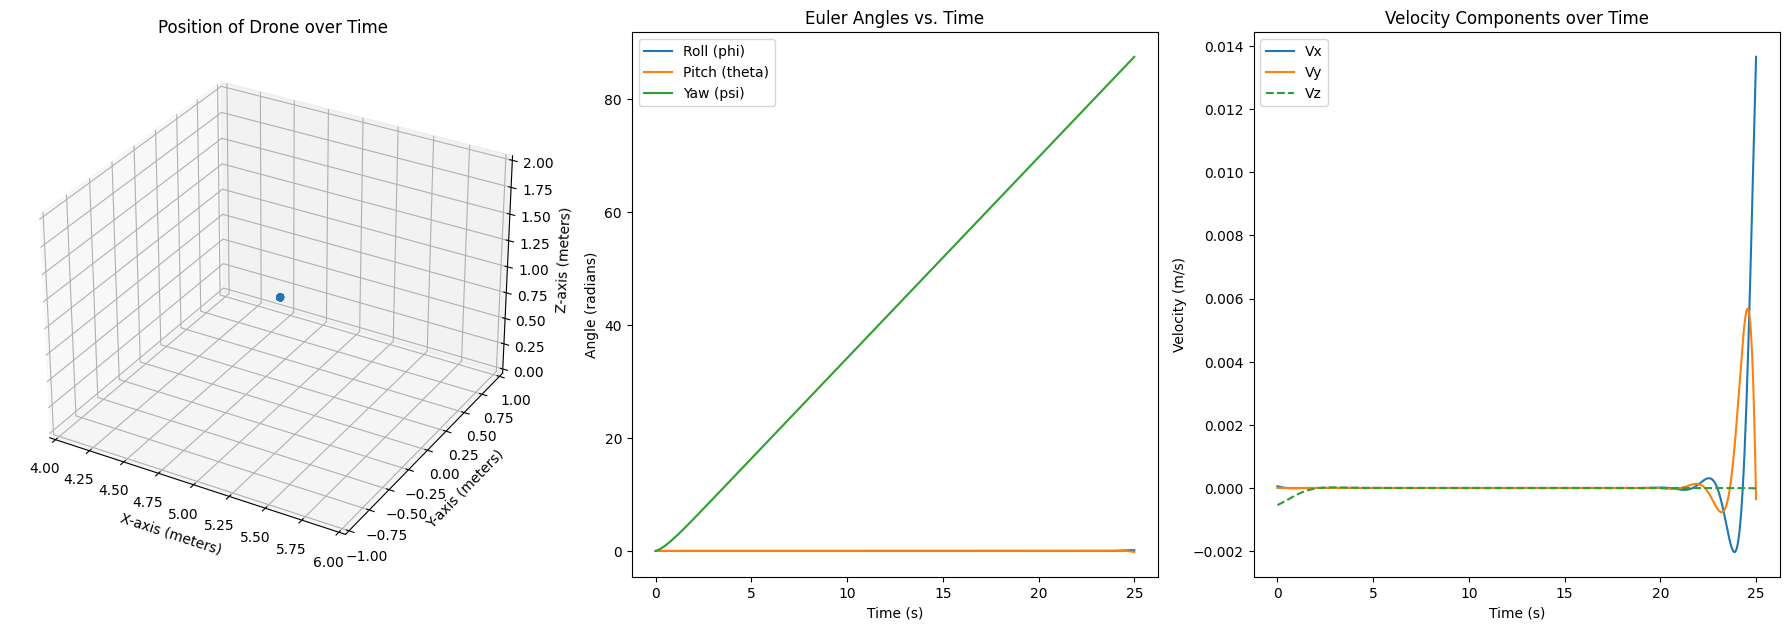

In [ ]:
steps = 500
time = 25
t = np.linspace(0, time, steps)

x_out, Px_output, Py_output, Pz_output, vx_output, vy_output, vz_output, phi_output, theta_output, psi_output, omegax_output, omegay_output, omegaz_output, omega1_output, omega2_output, omega3_output, omega4_output = sim(x_0, t, derivatives)

In [ ]:
energy1 = 0
power_total = 0
for i in range(len(Px_output)):
    x_desired = np.array([[5], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [psi_output[8] + 0.05], [0.0], [0.0], [0.0], [58.5534261852300], [58.5534261852300], [58.5534261852300], [58.5534261852300]]).T
    tau = controller.run(x_out[i], x_desired)
    tau1,tau2,tau3,tau4 =  tau
    power = (np.abs(tau1*omega1_output[i] / efficiency(tau1)) + np.abs(tau2*omega2_output[i] / efficiency(tau2))
    + np.abs(tau3*omega3_output[i] / efficiency(tau3)) + np.abs(tau4*omega4_output[i] / efficiency(tau4) ) )
    power_total += power
    energy1 = power_total * (time/steps)

In [ ]:
x_out.T[:,-1], energy_total + energy1, psi_output[-1],np.pi/2, energy1

(array([ 5.00286779e+00,  3.93534327e-03,  9.99996123e-01,  1.36608985e-02,
        -3.54722618e-04, -1.20086062e-05,  2.26768516e-03, -3.12652281e-03,
         1.52815388e+00, -3.57226077e-03, -1.01651796e-02,  6.21027700e-02,
         5.85539856e+01,  5.85553551e+01,  5.85529842e+01,  5.85518011e+01]),
 2585.654895781449,
 1.5281538800183054,
 1.5707963267948966,
 2551.5332882962853)

Step 5. Stop

In [ ]:
x_0 = x_out[-1]
energy_total =  energy_total + energy1
energy_total

2585.654895781449

Step 6. Build a New Equilibrium Controller about (pi / 2)



In [ ]:
#Equilibirum
Px, Py, Pz, vx, vy, vz, phi, theta, psi, omegax, omegay, omegaz, omega1, omega2, omega3, omega4 = symbols('Px, Py, Pz, vx, vy, vz, phi, theta, psi, omegax, omegay, omegaz, omega1, omega2, omega3, omega4')
tau1, tau2, tau3, tau4 = symbols('tau1, tau2, tau3, tau4')

# State and input matrices
State_Matrix = [Px, Py, Pz, vx, vy, vz, phi, theta, psi, omegax, omegay, omegaz, omega1, omega2, omega3, omega4]
inputs = [tau1, tau2, tau3, tau4]

#Equation of Motion
F  = Matrix([vx,
             vy,
             vz,
             k*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             -k*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             (g*m + k*(omega1**2 + omega2**2 + omega3**2 + omega4**2)*cos(phi)*cos(theta))/m,
             omegax,
             omegay,
             omegaz,
            (-I_xx*I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi)*tan(theta) - I_xx*I_zz*k*l*(omega1**2 - omega3**2)*sin(phi)*tan(theta) - I_yy*I_zz*k*l*(omega2**2 - omega4**2))/(I_xx*I_yy*I_zz),
            (I_yy*(tau1 - tau2 + tau3 - tau4)*sin(phi) - I_zz*k*l*(omega1**2 - omega3**2)*cos(phi))/(I_yy*I_zz),
            (-I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi) - I_zz*k*l*(omega1**2 - omega3**2)*sin(phi))/(I_yy*I_zz*cos(theta)),
            (-b*omega1**2 + tau1)/I_r,
            (-b*omega2**2 + tau2)/I_r,
            (-b*omega3**2 + tau3)/I_r,
            (-b*omega4**2 + tau4)/I_r]).T

# Define zero substitutions for various variables
zero_subs = {Px: 0.0, Py: 0.0, Pz: 0.0, vx: 0.0, vy: 0.0, vz: 0.0, phi: 0.0, theta: 0.0, psi: 0.0, omegax: 0.0, omegay: 0.0, omegaz: 0.0}

# Apply substitutions to F
F_equil = F.subs(zero_subs)
equations = [Eq(F_equil[i], 0.0) for i in [5, 6, 7, 8, 12, 13, 14, 15]]
tau_equations = [Eq(tau1, tau2), Eq(tau3, tau4), Eq(tau1, tau3)]
all_equations = equations + tau_equations
solution = solve(all_equations)[15]

solution_mapping = solution
initial_conditions = {
    'Px': 0.0, 'Py': 0.0, 'Pz': 0.0,
    'vx': 0.0, 'vy': 0.0, 'vz': 0.0,
    'phi': 0.0, 'theta': 0.0, 'psi': np.pi/2,
    'omegax': 0.0, 'omegay': 0.0, 'omegaz': 0.0
}

# Evaluate the equilibrium
F_equil = F_equil.subs(solution_mapping).subs(initial_conditions)
print(F_equil)

# Calculate the Jacobian matrix A
A = F.jacobian(State_Matrix)
A = A.subs(solution_mapping).subs(initial_conditions)
A = np.array(A).astype(float)

# Calculate the Jacobian matrix B
B = F.jacobian(inputs)
B = B.subs(solution_mapping).subs(initial_conditions)
B = np.array(B).astype(float)

# Evaluate the inputs and state matrix
inputs_equil = np.array(Matrix(inputs).subs(solution_mapping).subs(initial_conditions)).astype(float)
state_equil = np.array(Matrix(State_Matrix).subs(solution_mapping).subs(initial_conditions)).astype(float)
Q = np.diag([10,10,200,1,1,1,1,1,100,1,1,10,1,1,1,1])
R = np.eye(4)*10
K = LQR(A, B, Q, R)


Matrix([[0, 0, 0, 0, 0, 1.77635683940025e-15, 0, 0, 0, 0, 0, 0, -1.42108547152020e-13, -1.42108547152020e-13, -1.42108547152020e-13, -1.42108547152020e-13]])


In [ ]:
x_desired = np.array([[5], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [np.pi/2], [0.0], [0.0], [0.0], [58.5534261852300], [58.5534261852300], [58.5534261852300], [58.5534261852300]]).T
def derivatives(x, K, x_desired = x_desired):
  Px, Py, Pz, vx, vy, vz, phi, theta,  psi, omegax, omegay, omegaz ,omega1 ,omega2, omega3, omega4 = (x)
  tau = controller.run(x, x_desired)
  tau1,tau2,tau3,tau4 =  tau
  F  = np.array([vx,
             vy,
             vz,
             k*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             -k*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             (g*m + k*(omega1**2 + omega2**2 + omega3**2 + omega4**2)*cos(phi)*cos(theta))/m,
             omegax,
             omegay,
             omegaz,
            (-I_xx*I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi)*tan(theta) - I_xx*I_zz*k*l*(omega1**2 - omega3**2)*sin(phi)*tan(theta) - I_yy*I_zz*k*l*(omega2**2 - omega4**2))/(I_xx*I_yy*I_zz),
            (I_yy*(tau1 - tau2 + tau3 - tau4)*sin(phi) - I_zz*k*l*(omega1**2 - omega3**2)*cos(phi))/(I_yy*I_zz),
            (-I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi) - I_zz*k*l*(omega1**2 - omega3**2)*sin(phi))/(I_yy*I_zz*cos(theta)),
            (-b*omega1**2 + tau1)/I_r,
            (-b*omega2**2 + tau2)/I_r,
            (-b*omega3**2 + tau3)/I_r,
            (-b*omega4**2 + tau4)/I_r]).astype(float)
  return F

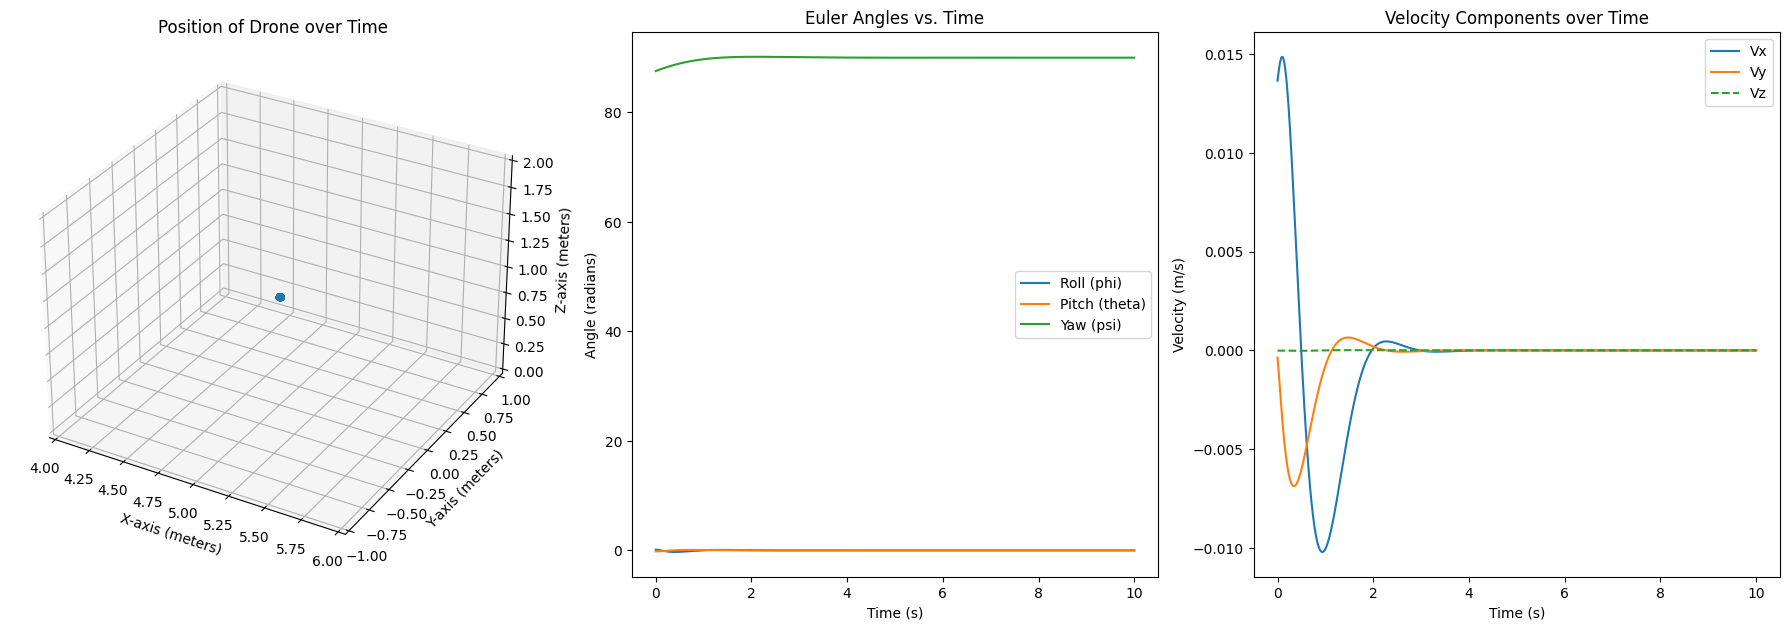

In [ ]:
time =10
steps = 1000
t = np.linspace(0, time, steps)

x_out, Px_output, Py_output, Pz_output, vx_output, vy_output, vz_output, phi_output, theta_output, psi_output, omegax_output, omegay_output, omegaz_output, omega1_output, omega2_output, omega3_output, omega4_output = sim(x_0, t, derivatives)

In [ ]:
energy1 = 0
power_total = 0
for i in range(len(Px_output)):
    x_desired = np.array([[5], [0.0], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [np.pi / 2], [0.0], [0.0], [0.0], [58.5534261852300], [58.5534261852300], [58.5534261852300], [58.5534261852300]]).T
    tau = controller.run(x_out[i], x_desired)
    tau1,tau2,tau3,tau4 =  tau
    power = (np.abs(tau1*omega1_output[i] / efficiency(tau1)) + np.abs(tau2*omega2_output[i] / efficiency(tau2))
    + np.abs(tau3*omega3_output[i] / efficiency(tau3)) + np.abs(tau4*omega4_output[i] / efficiency(tau4) ) )
    power_total += power
    energy1 = power_total * (time/steps)

In [ ]:
x_out[-1], energy_total + energy1, energy1

(array([ 5.00000000e+00,  4.20895735e-11,  1.00000000e+00,  5.14873516e-10,
        -1.52801822e-10, -9.55119738e-10, -2.23117220e-10,  1.71003785e-11,
         1.57079690e+00,  2.80989917e-10,  1.30888708e-10, -9.36408534e-07,
         5.85534245e+01,  5.85534279e+01,  5.85534245e+01,  5.85534279e+01]),
 2619.389549388371,
 33.734653606922315)

Step 7. Move forward 5m

In [ ]:
x_0 = x_out[-1]
energy_total = energy_total +energy1
energy_total

2619.389549388371

In [ ]:
def derivatives(x, K, x_desired = x_desired):
  Px, Py, Pz, vx, vy, vz, phi, theta,  psi, omegax, omegay, omegaz ,omega1 ,omega2, omega3, omega4 = (x)
  x_desired = np.array([[5], [x[1] + 0.8], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [np.pi / 2], [0.0], [0.0], [0.0], [58.5534261852300], [58.5534261852300], [58.5534261852300], [58.5534261852300]]).T
  tau = controller.run(x, x_desired)
  tau1,tau2,tau3,tau4 =  tau
  F  = np.array([vx,
             vy,
             vz,
             k*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             -k*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             (g*m + k*(omega1**2 + omega2**2 + omega3**2 + omega4**2)*cos(phi)*cos(theta))/m,
             omegax,
             omegay,
             omegaz,
            (-I_xx*I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi)*tan(theta) - I_xx*I_zz*k*l*(omega1**2 - omega3**2)*sin(phi)*tan(theta) - I_yy*I_zz*k*l*(omega2**2 - omega4**2))/(I_xx*I_yy*I_zz),
            (I_yy*(tau1 - tau2 + tau3 - tau4)*sin(phi) - I_zz*k*l*(omega1**2 - omega3**2)*cos(phi))/(I_yy*I_zz),
            (-I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi) - I_zz*k*l*(omega1**2 - omega3**2)*sin(phi))/(I_yy*I_zz*cos(theta)),
            (-b*omega1**2 + tau1)/I_r,
            (-b*omega2**2 + tau2)/I_r,
            (-b*omega3**2 + tau3)/I_r,
            (-b*omega4**2 + tau4)/I_r]).astype(float)
  return F

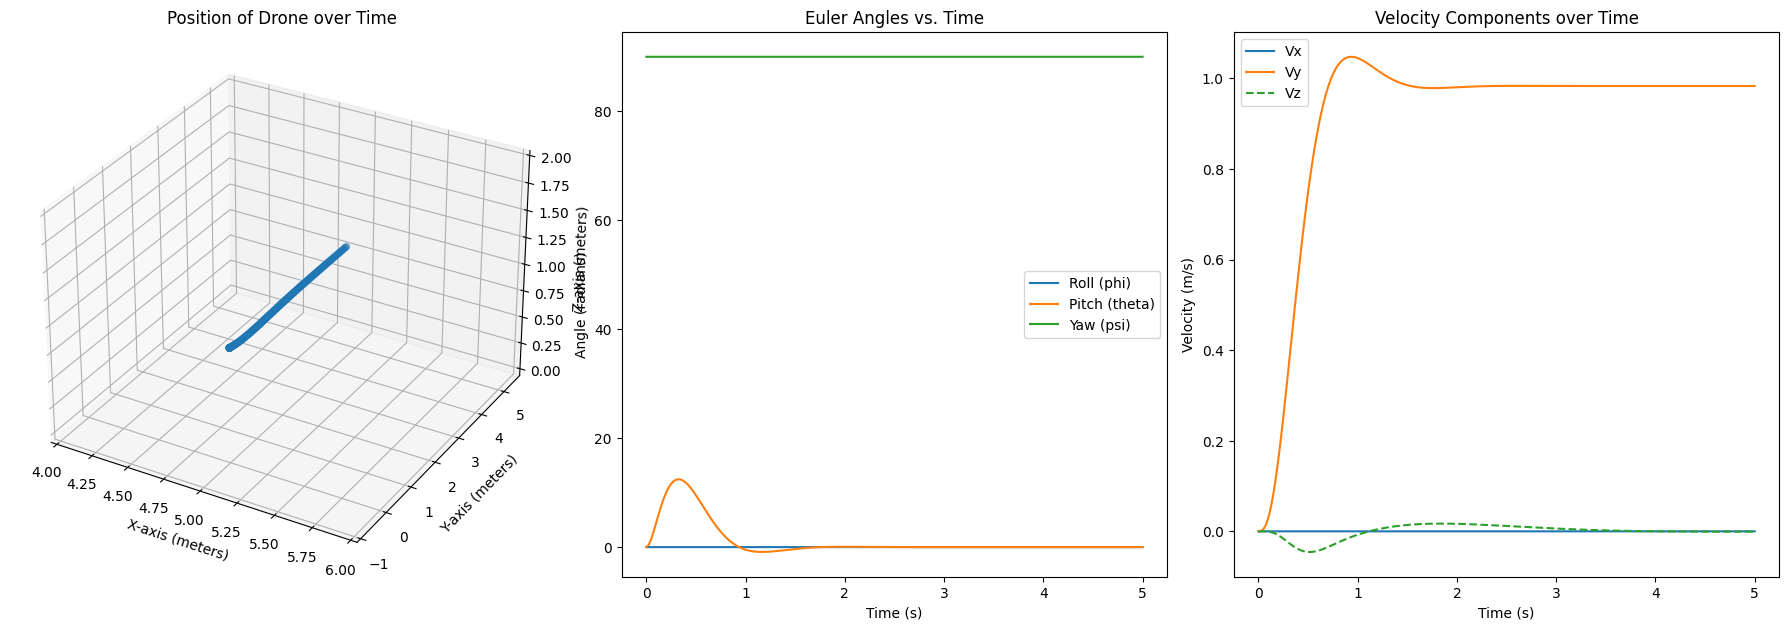

4.578516807723917

In [ ]:
steps = 200
time = 5
t = np.linspace(0, time, steps)
x_out, Px_output, Py_output, Pz_output, vx_output, vy_output, vz_output, phi_output, theta_output, psi_output, omegax_output, omegay_output, omegaz_output, omega1_output, omega2_output, omega3_output, omega4_output = sim(x_0, t, derivatives)
Py_output[-1]

In [ ]:
energy1 = 0
power_total = 0
for i in range(len(Px_output)):
  x_desired = np.array([[5], [x_out[i,1] + 0.8], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [np.pi / 2], [0.0], [0.0], [0.0], [58.5534261852300], [58.5534261852300], [58.5534261852300], [58.5534261852300]]).T
  tau = controller.run(x_out[i], x_desired)
  tau1,tau2,tau3,tau4 =  tau
  power = (np.abs(tau1*omega1_output[i] / efficiency(tau1)) + np.abs(tau2*omega2_output[i] / efficiency(tau2))
  + np.abs(tau3*omega3_output[i] / efficiency(tau3)) + np.abs(tau4*omega4_output[i] / efficiency(tau4) ) )
  power_total += power
  energy1 = power_total * (time/steps)


In [ ]:
x_out[-1], energy_total + energy1

(array([ 5.00000000e+00,  4.57851681e+00,  1.00048231e+00,  8.87857262e-09,
         9.83424607e-01, -6.76734580e-04, -8.39092179e-10, -3.28935592e-08,
         1.57079692e+00, -7.30150828e-09,  4.82930865e-07, -6.44537675e-07,
         5.85544257e+01,  5.85544249e+01,  5.85544254e+01,  5.85544249e+01]),
 2638.1952392858643)

Step 8. Hover

In [ ]:
x_0 = x_out[-1]
energy_total = energy_total + energy1
energy_total

2638.1952392858643

In [ ]:
x_desired = np.array([[5], [5], [1.0], [0.0], [0.0], [0.0], [0.0], [0.0], [np.pi / 2], [0.0], [0.0], [0.0], [58.5534261852300], [58.5534261852300], [58.5534261852300], [58.5534261852300]]).T
def derivatives(x, K, x_desired = x_desired):
  Px, Py, Pz, vx, vy, vz, phi, theta,  psi, omegax, omegay, omegaz ,omega1 ,omega2, omega3, omega4 = (x)
  tau = controller.run(x, x_desired)
  tau1,tau2,tau3,tau4 =  tau
  F  = np.array([vx,
             vy,
             vz,
             k*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             -k*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             (g*m + k*(omega1**2 + omega2**2 + omega3**2 + omega4**2)*cos(phi)*cos(theta))/m,
             omegax,
             omegay,
             omegaz,
            (-I_xx*I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi)*tan(theta) - I_xx*I_zz*k*l*(omega1**2 - omega3**2)*sin(phi)*tan(theta) - I_yy*I_zz*k*l*(omega2**2 - omega4**2))/(I_xx*I_yy*I_zz),
            (I_yy*(tau1 - tau2 + tau3 - tau4)*sin(phi) - I_zz*k*l*(omega1**2 - omega3**2)*cos(phi))/(I_yy*I_zz),
            (-I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi) - I_zz*k*l*(omega1**2 - omega3**2)*sin(phi))/(I_yy*I_zz*cos(theta)),
            (-b*omega1**2 + tau1)/I_r,
            (-b*omega2**2 + tau2)/I_r,
            (-b*omega3**2 + tau3)/I_r,
            (-b*omega4**2 + tau4)/I_r]).astype(float)
  return F

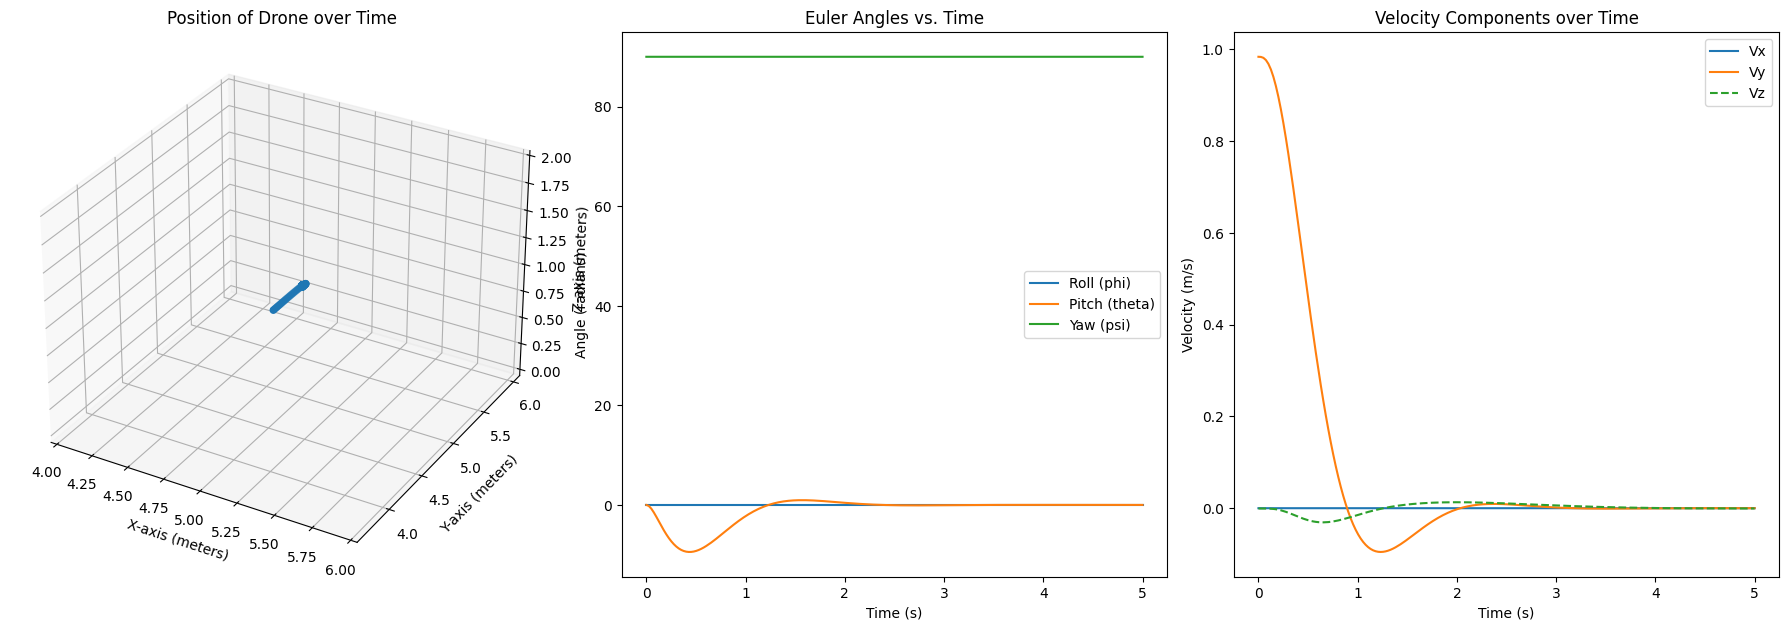

4.999994367809076

In [ ]:
steps = 200
time = 5
t = np.linspace(0, time, steps)
x_out, Px_output, Py_output, Pz_output, vx_output, vy_output, vz_output, phi_output, theta_output, psi_output, omegax_output, omegay_output, omegaz_output, omega1_output, omega2_output, omega3_output, omega4_output = sim(x_0, t, derivatives)
Py_output[-1]

In [ ]:
def energy(x_out, x_desired, time, steps):
    power_total = 0
    energy = 0
    for i in range(len(Px_output)):
      tau = controller.run(x_out[i], x_desired)
      tau1,tau2,tau3,tau4 =  tau
      power = (np.abs(tau1*omega1_output[i] / efficiency(tau1)) + np.abs(tau2*omega2_output[i] / efficiency(tau2))
      + np.abs(tau3*omega3_output[i] / efficiency(tau3)) + np.abs(tau4*omega4_output[i] / efficiency(tau4) ) )
      power_total += power
      energy = power_total * (time/steps)
    return energy
x_out[-1], energy_total + energy(x_out, x_desired, time, steps)

(array([ 5.00000000e+00,  4.99999437e+00,  1.00045472e+00, -2.35184131e-09,
         5.25893936e-05, -5.43619541e-04, -7.22230601e-10, -1.51414309e-05,
         1.57079648e+00,  5.79297660e-09, -9.39629075e-07, -1.58809787e-07,
         5.85537418e+01,  5.85537528e+01,  5.85537643e+01,  5.85537528e+01]),
 2655.965669495927)

Step 9. Land

In [ ]:
x_0 = x_out[-1]
energy_total =  energy_total+energy(x_out, x_desired, time, steps)
energy_total

2655.965669495927

In [ ]:
x_desired = np.array([[5], [5], [0.02], [0.0], [0.0], [0.0], [0.0], [0.0], [np.pi / 2], [0.0], [0.0], [0.0], [58.5534261852300], [58.5534261852300], [58.5534261852300], [58.5534261852300]]).T
def derivatives(x, K, x_desired = x_desired):
  Px, Py, Pz, vx, vy, vz, phi, theta,  psi, omegax, omegay, omegaz ,omega1 ,omega2, omega3, omega4 = (x)
  tau = controller.run(x, x_desired)
  tau1,tau2,tau3,tau4 =  tau
  F  = np.array([vx,
             vy,
             vz,
             k*(sin(phi)*sin(psi) + sin(theta)*cos(phi)*cos(psi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             -k*(sin(phi)*cos(psi) - sin(psi)*sin(theta)*cos(phi))*(omega1**2 + omega2**2 + omega3**2 + omega4**2)/m,
             (g*m + k*(omega1**2 + omega2**2 + omega3**2 + omega4**2)*cos(phi)*cos(theta))/m,
             omegax,
             omegay,
             omegaz,
            (-I_xx*I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi)*tan(theta) - I_xx*I_zz*k*l*(omega1**2 - omega3**2)*sin(phi)*tan(theta) - I_yy*I_zz*k*l*(omega2**2 - omega4**2))/(I_xx*I_yy*I_zz),
            (I_yy*(tau1 - tau2 + tau3 - tau4)*sin(phi) - I_zz*k*l*(omega1**2 - omega3**2)*cos(phi))/(I_yy*I_zz),
            (-I_yy*(tau1 - tau2 + tau3 - tau4)*cos(phi) - I_zz*k*l*(omega1**2 - omega3**2)*sin(phi))/(I_yy*I_zz*cos(theta)),
            (-b*omega1**2 + tau1)/I_r,
            (-b*omega2**2 + tau2)/I_r,
            (-b*omega3**2 + tau3)/I_r,
            (-b*omega4**2 + tau4)/I_r]).astype(float)
  return F

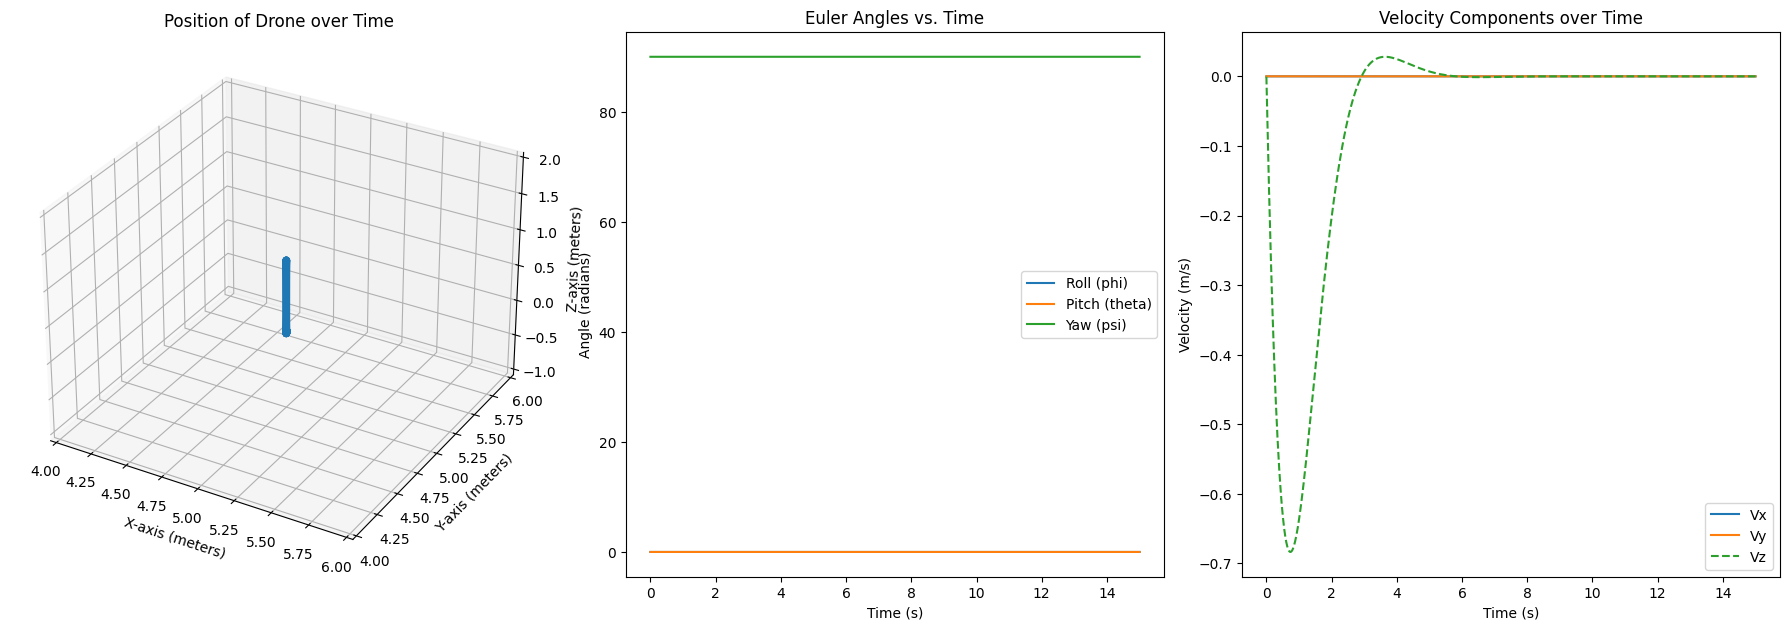

In [ ]:
steps = 1500
time = 15
t = np.linspace(0, time, steps)
x_out, Px_output, Py_output, Pz_output, vx_output, vy_output, vz_output, phi_output, theta_output, psi_output, omegax_output, omegay_output, omegaz_output, omega1_output, omega2_output, omega3_output, omega4_output = sim(x_0, t, derivatives)

In [ ]:
for i, z in enumerate(Pz_output):
    if z < 0.:
        print(vz_output[i], vz_output[i] > -0.01)

-0.08706711902209888 False
-0.08468791766341588 False
-0.08234063093659272 False
-0.08002511346732047 False
-0.07774121555496273 False
-0.07548878259181539 False
-0.07326765716450705 False
-0.07107767764953214 False
-0.06891867877594195 False
-0.0667904905724036 False
-0.06469294001093592 False
-0.06262585140997254 False
-0.060589045455936054 False
-0.058582339602597844 False
-0.056605547013917304 False
-0.05465847957634091 False
-0.052740945770141365 False
-0.05085275138078559 False
-0.04899369918517952 False
-0.047163589532160814 False
-0.04536222072396361 False
-0.04358938860276281 False
-0.04184488680374851 False
-0.040128506240146564 False
-0.03844003664416304 False
-0.036779265583834556 False
-0.03514597885530767 False
-0.033539959919555024 False
-0.03196099072939597 False
-0.030408852414002645 False
-0.02888332433247882 False
-0.027384184538329158 False
-0.025911209576147096 False
-0.024464173221470053 False
-0.023042850612435 False
-0.021647014936916873 False
-0.020276438468040

In [ ]:
E_final = energy_total + energy(x_out,x_desired, time,steps )
E_final

NameError: name 'x_output' is not defined